# About this notebook

This is a **part one notebook** in the *Receipt OCR with OpenCV* series and will cover the first step of the process: getting a scanned version of the receipt. In order to complete this task we will:
* Locate receipt contour on the photo
* Crop image to the receipt contour
* Apply perspective restoration

Let's get started!

In [15]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from skimage.filters import threshold_local
from PIL import Image

import re
import pandas as pd

from PIL import Image
import pytesseract
from datetime import datetime
import os

Receipt images used in this notebook come from a tiny [personal receipt dataset](https://www.kaggle.com/dmitryyemelyanov/personal-receipt-collection). Let's check out one of them:

# Step 1: Receipt Contour Detection
In order to find receipt contour, standart edge detection preprocessing is applied:
* Convert image to grayscale
* Aplly Gaussian filter 5x5 to get rid of noise
* Run Canny edge detector

Let's define some utility methods:

In [16]:
def opencv_resize(image, ratio):
    width = int(image.shape[1] * ratio)
    height = int(image.shape[0] * ratio)
    dim = (width, height)
    return cv2.resize(image, dim, interpolation=cv2.INTER_AREA)

def plot_rgb(image):
    plt.figure(figsize=(16, 10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

def plot_gray(image):
    plt.figure(figsize=(16, 10))
    return plt.imshow(image, cmap="Greys_r")

# approximate the contour by a more primitive polygon shape
def approximate_contour(contour):
    peri = cv2.arcLength(contour, True)
    return cv2.approxPolyDP(contour, 0.032 * peri, True)

def get_receipt_contour(contours):
    # loop over the contours
    for c in contours:
        approx = approximate_contour(c)
        # if our approximated contour has four points, we can assume it is receipt's rectangle
        if len(approx) == 4:
            return approx

def contour_to_rect(contour):
    pts = contour.reshape(4, 2)
    rect = np.zeros((4, 2), dtype="float32")
    # top-left point has the smallest sum
    # bottom-right has the largest sum
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # compute the difference between the points:
    # the top-right will have the minumum difference
    # the bottom-left will have the maximum difference
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect / resize_ratio

def wrap_perspective(img, rect):
    # unpack rectangle points: top left, top right, bottom right, bottom left
    (tl, tr, br, bl) = rect
    # compute the width of the new image
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    # compute the height of the new image
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    # take the maximum of the width and height values to reach
    # our final dimensions
    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))
    # destination points which will be used to map the screen to a "scanned" view
    dst = np.array(
        [[0, 0], [maxWidth - 1, 0], [maxWidth - 1, maxHeight - 1], [0, maxHeight - 1]],
        dtype="float32",
    )
    # calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(rect, dst)
    # warp the perspective to grab the screen
    return cv2.warpPerspective(img, M, (maxWidth, maxHeight))




In [14]:
# Sample file out of the dataset

for file in os.listdir("./pictures"):
    
    try:
        #file_name = "Ultra-Rare-Pokemon-Card-Shiny-Machamp-1st-Edition.jpg"
        image = cv2.imread("./pictures/" + file)
        
        # Downscale image as finding receipt contour is more efficient on a small image
        resize_ratio = 500 / image.shape[0]
        original = image.copy()
        image = opencv_resize(image, resize_ratio)
        
        # Convert to grayscale for further processing
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        #plot_gray(gray)
        
        # Get rid of noise with Gaussian Blur filter
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        #plot_gray(blurred)
        
        # Detect white regions
        rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
        dilated = cv2.dilate(blurred, rectKernel)
        #plot_gray(dilated)
        
        edged = cv2.Canny(dilated, 20, 200, apertureSize=3)
        #plot_gray(edged)
        
        # Detect all contours in Canny-edged image
        contours, hierarchy = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        image_with_contours = cv2.drawContours(image.copy(), contours, -1, (0, 255, 0), 3)
        #plot_rgb(image_with_contours)
        
        # Get 10 largest contours
        largest_contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]
        image_with_largest_contours = cv2.drawContours(
            image.copy(), largest_contours, -1, (0, 255, 0), 3
        )
        #plot_rgb(image_with_largest_contours)
        
        
        
        get_receipt_contour(largest_contours)
        
        
        
        receipt_contour = get_receipt_contour(largest_contours)
        image_with_receipt_contour = cv2.drawContours(
            image.copy(), [receipt_contour], -1, (0, 255, 0), 2
        )
        #plot_rgb(image_with_receipt_contour)
        
        
        scanned = wrap_perspective(original.copy(), contour_to_rect(receipt_contour))
        plt.figure(figsize=(16, 10))
        scanned = cv2.cvtColor(scanned, cv2.COLOR_BGR2RGB)
        #plt.imshow(scanned)
        
        
        
        custom_oem_psm_config = r"--oem 1 --psm 6"
        test = pytesseract.image_to_string(scanned, config=custom_oem_psm_config)
        
        names = pd.read_csv("pokemon_list.csv")
        s = test.lower()
        
        pointer = 0
        
        for name in names["Name"]:
            match = re.search(name.lower(), s)
            if match != None:
                print("Full match: % s" % (match.group(0)))
                output = Image.fromarray(scanned)
                output.save(match.group(0) + "_" + datetime.now().strftime("%m-%d-%Y-%H:%M:%S") + ".png")
                pointer = pointer + 1
            
        if pointer == 0:
            output = Image.fromarray(scanned)
            output.save("result" + datetime.now().strftime("%m-%d-%Y-%H:%M:%S") + ".png")
    
    except Exception as e:
        print(e)
        continue

Full match: alakazam
Full match: abra
Full match: kadabra
Full match: gastly
Full match: durant
Full match: duskull
Full match: abra
OpenCV(4.5.5) /build/opencv/src/opencv-4.5.5/modules/imgproc/src/drawing.cpp:2599: error: (-215:Assertion failed) reader.ptr != NULL in function 'cvDrawContours'

Full match: slowpoke
Full match: slowpoke
Full match: abra
Full match: kadabra
Full match: abra
Full match: drowzee
Full match: drowzee
Full match: durant
Full match: gastly
Full match: haunter
Full match: hypno
Full match: gastly
Full match: haunter
Full match: natu


<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

Match Found
https://pkmncards.com/card/natu-neo-genesis-67


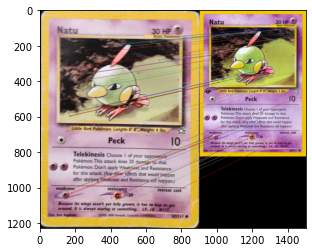

KeyboardInterrupt: 

In [45]:
import cv2

for image in os.listdir():
    if image.endswith('.png'):
        img1 = cv2.imread(image, 4)
        for comparison in os.listdir((os.getcwd() + '/.simlinks/')):
            #print(image.split('_')[0], comparison)
            if image.split('_')[0] in comparison:
                #print(image, comparison)
                try:
                    # req = urlopen(url)
                    
                    img2 = cv2.imread((os.getcwd() + '/.simlinks/' + comparison), 4)
                    
                    # Initiate SURF detector
                    surf = cv2.xfeatures2d.SURF_create()
                    
                    # find the keypoints and descriptors with SURF
                    kp1, des1 = surf.detectAndCompute(img1, None)
                    kp2, des2 = surf.detectAndCompute(img2, None)
                    
                    # BFMatcher with default params
                    bf = cv2.BFMatcher()
                    matches = bf.knnMatch(des1, des2, k=2)
                    
                    how_many_found = 0
                    
                    # Apply ratio test
                    good = []
                    for m, n in matches:
                        if m.distance < 0.4 * n.distance:
                            good.append([m])
                            a = len(good)
                            percent = (a * 100) / len(kp2)
                            #print("{} % similarity".format(percent))
                            if percent * 100 >= 99.00:
                                print("Match Found")
                                print('https://pkmncards.com/card/' + comparison[:-4])
                                img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good, None, flags=2)
                                img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
                                plt.imshow(img3), plt.show()
                                #print(elenco[elenco["Immagine"] == url])
                                ++how_many_found
                                break
                    
                    # img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=2)
                    # plt.imshow(img3),plt.show()
            
                except Exception as e:
                    print(e)
                    continue

> It is also important to get down to just four contour points, as we will need them for perspective restoration

# Step 2: Cropping and perspective restoration

We will make use of `cv2.warpPerspective` to restore perspective of the receipt. We have to do some preparations though:
* convert contour into a rectangle-like coordinate array consisting of clockwise ordered points: top-left, top-right, bottom-right, bottom-left
* use rectangle points to calculate destination points of the "scanned" view
* feed destination points into `cv2.getPerspectiveTransform` to calculate transformation matrix
* and finally use `cv2.warpPerspective` to restore the perspective!